In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, \
                                    Dense, Dropout, Conv2DTranspose,\
                                    BatchNormalization   


from IPython import display                                 

## Loading the Dataset

In [0]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)\
                           .astype('float32')
                           
train_images = train_images/127.5 # Scale values ranging from 0-255 to 0-2
train_images = train_images - 1   # Scale values from 0-2 to -1 to 1

In [0]:
## Size of the Dataset
DATASET_SIZE = train_images.shape[0]

## Getting the Width, Height and Columns in the Train Images
W, H, C = train_images.shape[1:]  

## Setting the batch size
BATCH_SIZE = 256

## Setting the latent noise dimension
latent_noise_dim = 100

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)\
                               .shuffle(DATASET_SIZE)\
                               .batch(BATCH_SIZE)

## Creating the Models

### The Generator

For the Generator we will begin with a latent noise as input, pass it to Dense Layer and use Conv2DTranspose (Unsampling) Layers to produce an Image of the size same as our train samples. 

For all the layers we will use LeakyReLU activation except the last one which will have tanh to give value between -1 to 1

In [0]:
def create_generator(latent_noise_dim):
  model = tf.keras.Sequential()

  model.add(Dense(7 * 7 * 256, use_bias=False, input_shape=(latent_noise_dim,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  
  model.add(layers.Reshape((7, 7, 256)))
  ## By now the output is of the size (BatchSize, 7, 7, 256)

  model.add(Conv2DTranspose(128, (5,5), strides=(1,1), padding = 'same', 
                            use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  ## By now the ourput is of the size (BatchSize, 7, 7, 128)

  model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding = 'same', 
                            use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  ## By now the ourput is of the size (BatchSize, 14, 14, 64)

  model.add(Conv2DTranspose(1, (5,5), strides=(2,2), padding = 'same', 
                            use_bias=False, activation = 'tanh'))
  ## By now the outpur is of the size (BatchSize, 28, 28, 1) with values
  ## in the range -1 to 1 thus matching properties of normalized train images

  return model

In [0]:
## Viewing the Generator Model
generator = create_generator(latent_noise_dim)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

#### Creating an Image from the untrained Generator

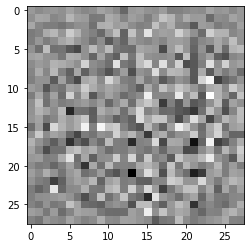

In [0]:
noise = tf.random.normal([1, 100])
generator_output = generator(noise)

plt.imshow((generator_output[0, :, :, 0] + 1) * 127.5, cmap ='gray')

### The Discriminator

Build an Image Classifier as if it would be used for simple MNIST Digit Classification. That's what Discriminator actually is. An Image Classifier.

In [0]:
def create_discriminator():
  model = tf.keras.Sequential()

  model.add(Conv2D(64, (5,5), strides=(2,2), padding='same',
                   input_shape = [W, H, C]))
  model.add(LeakyReLU())
  model.add(Dropout(.3))

  model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(.3))

  model.add(Flatten())
  model.add(Dense(1))

  return model

In [0]:
## Viewing the Discriminator Model
discriminator = create_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

The discriminator should be able to classify the generated image as real or fake. The traning would be so that it outputs positive values for real images and negative values for fake images. 

In [0]:
discriminator_output = discriminator(generator_output)
print(discriminator_output)

tf.Tensor([[-0.00185508]], shape=(1, 1), dtype=float32)


## Defining the Loss Functions and Optimizers

In [0]:
## Need this in our generator and discriminator loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss Function

The loss function for the discriminator should quantify how well the discriminator can distinguish real images from fake images. So, we compare discriminator's output on real images to array of 1s, and fake images output to array of 0s.

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

### Generator Loss Function

The loss function for the discriminator should quantify how well can it trick the discriminator. We compare discriminator's output on fake images to array of 1s. Thus while discriminator tries to make the output of fake images to 0 generator wants it to be 1. 

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizers

In [0]:
# The generator and discriminator each gets its own optimizer
generator_optimizer = tf.keras.optimizers.Adam(12e-5, .5)
discriminator_optimizer = tf.keras.optimizers.Adam(12e-5, .5)

In [0]:
checkpoint_dir = './train_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Defining the Training Loop

In [0]:
## In order to compare our model performance we will use a fixed validation
## seed to generate fixed number of images and see the output of it
no_validation_images = 16
validation_seed = tf.random.normal([no_validation_images, latent_noise_dim])

The training function for one batch receives a array of real images which is random BATCH_SIZE no of samples of train images.


One batch of training function works like this: 
1. Prepare random noise of BATCH_SIZE, latent_dim_shape
2. Get generated images from the generator
3. Get output of dicriminator on Real and Fake (Generated) images
4. Compute loss of generator and discriminator
5. Propogate the loss for each model individually



In [0]:
# Since it will be called repeatedly we use @tf.function annotation
# This will compile the function saving execution time

@tf.function
def train_one_batch(real_images):
  ## Generate random noise
  random_noise = tf.random.normal([BATCH_SIZE, latent_noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    ## Generate images using Generator
    generated_images = generator(random_noise, training = True)

    ## Get the output of dicriminator on real and generate images
    real_output = discriminator(real_images, training = True)
    fake_output = discriminator(generated_images, training=True)

    ## Get loss of generator and dicriminator
    loss_generator = generator_loss(fake_output)
    loss_dicriminator = discriminator_loss(real_output, fake_output)

    ## Compute Gradients of generator and dicriminator
    generator_gradients = gen_tape.gradient(loss_generator, 
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(loss_dicriminator, 
                                                 discriminator.\
                                                 trainable_variables)
    
    ## Apply backprop using the computed gradients
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.\
                                                 trainable_variables))

In [0]:
def fit(dataset, epochs):
  for epoch in range(1, epochs + 1):
    for batch in dataset:
      train_one_batch(batch)


    display.clear_output(wait=True)
    visualize_validation_output(generator, epoch, validation_seed)

    if (epoch) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
  
  display.clear_output(wait=True)
  visualize_validation_output(generator, epochs + 1, validation_seed)

### Some helper functions used for image plotting

In [0]:
def visualize_validation_output(model, epoch, validation_seed):
  generated_images = model(validation_seed, training = False)

  fig = plt.figure(figsize = (4,4))

  for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow((generated_images[i, :, :, 0] + 1) * 127.5, cmap = 'gray')
    plt.axis('off')
  
  fig.suptitle('Output at epoch {:03}'.format(epoch))
  plt.savefig('validation_images_{:03}.png'.format(epoch))
  plt.show()

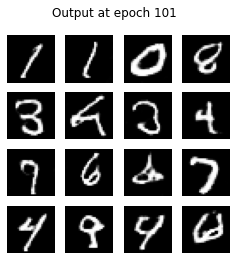

In [0]:
fit(train_dataset, 100)

## Creating GIF

In [0]:
import glob
import imageio

In [0]:
gif_file = 'model_behaviour.gif'

with imageio.get_writer(gif_file, mode='I') as writer:
  filenames = glob.glob('val*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)